# Slice Size Analysis
This notebook reproduces the statistics and figures in Section 3 of the paper "Helping Programmers Find Relevant Code with Modular Slices".

In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype as Category
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
import numpy as np
from iterextras import par_for
import subprocess as sp
import os
import itertools
from tqdm.auto import tqdm
from scipy.stats import gmean
import matplotlib as mpl
import json
import statsmodels.formula.api as sm
from matplotlib import rc
import subprocess as sp

sns.set(
    style='whitegrid',
    palette='tab10', 
    
    ### Uncomment the code below to get the figures to look *exactly* like the paper.
    ### Requires LaTeX to be installed.
    
    rc={
        'font.family': 'serif', 
        'font.serif': ['Linux Libertine O'],
        'text.usetex': True,
        'text.latex.preamble': r'\usepackage{libertine}\usepackage[libertine]{newtxmath}'
    }
)

In [2]:
PATHS = glob('../data/slices/*.json')
CRATES = [os.path.splitext(os.path.basename(path))[0] for path in PATHS]
crate_cat = Category(sorted(CRATES))

def parse_data(path):
    print(path)
    if os.stat(path).st_size == 0:
        return []
    
    crate = os.path.splitext(os.path.basename(path))[0]
    df = pd.read_json(path)
    df['crate'] = crate
    df['crate'] = df['crate'].astype(crate_cat)
    return df


df = pd.concat(par_for(parse_data, PATHS)).reset_index()
df = df[df.num_lines > 0]

../data/slices/rav1e.json
../data/slices/hyper.json
../data/slices/image.json
../data/slices/RustPython.json
../data/slices/rg3d.json
../data/slices/rayon.json
../data/slices/rustls.json
../data/slices/Rocket.json
../data/slices/nalgebra.json
../data/slices/sccache.json


  0%|          | 0/10 [00:02<?, ?it/s]

In [3]:
df['tok_frac'] = df.num_relevant_tokens / df.num_tokens
df['line_frac'] = df.num_relevant_lines / df.num_lines

cutoff = int(np.round(df.num_lines.mean()))
df['big_func'] = df.num_lines >= cutoff
df['func_bin'] = df.num_lines // 50 * 50
df['func_quartile'] = pd.qcut(df.num_lines, [0, 0.25, 0.5, 0.75, 1.])

# Methodology (Section 3.1)




## Table 1

In [4]:
CRATE_INFO = [
    ('Rocket', 'core/lib', 'Web backend framework', 'https://github.com/SergioBenitez/Rocket'),
    ('image', None, 'Image processing library', 'https://github.com/image-rs/image'),
    ('rayon', None, 'Data parallelism library', 'https://github.com/rayon-rs/rayon'),
    ('rg3d', None, '3D game engine', 'https://github.com/mrDIMAS/rg3d'),    
    ('nalgebra', None, 'Numerics library', 'https://github.com/dimforge/nalgebra'),
    ('rustls', 'rustls', 'TLS implementation', 'https://github.com/ctz/rustls'),
    ('sccache', None, 'Distributed build cache', 'https://github.com/mozilla/sccache'),
    ('hyper', None, 'HTTP server', 'https://github.com/hyperium/hyper'),    
    ('rav1e', None, 'Video encoder', 'https://github.com/xiph/rav1e'),
    ('RustPython', 'vm', 'Python interpreter', 'https://github.com/RustPython/RustPython'),
]

In [5]:
bwd = df[df.direction == 'Backward']
counts = bwd.groupby(['crate', 'function_path']).size().rename('count')
counts = counts[counts > 0].reset_index()

num_funcs = counts.groupby('crate').size().rename('num_funcs')
num_slices = counts.groupby('crate')['count'].sum().rename('num_slices')
avg_slices_per_func = counts.groupby('crate')['count'].mean().rename('avg_slices_per_func')
crate_stats = pd.concat([num_slices, avg_slices_per_func, num_funcs], axis=1).sort_values('num_slices')
crate_stats

,num_slices,avg_slices_per_func,num_funcs
crate,,,
Rocket,7623,10.218499,746
rayon,10958,9.247257,1185
hyper,10968,13.761606,797
sccache,13464,20.906832,644
rustls,15433,17.320988,891
nalgebra,28248,15.658537,1804
image,29705,26.194885,1134
rg3d,46865,13.572256,3453
rav1e,57713,61.725134,935


In [6]:
CLOC = 'cloc'
crate_loc = []
for (crate, path, purpose, url) in CRATE_INFO:
    crate_dir = f'../data/repos/{crate}'
    if path:
        crate_dir += f'/{path}'
    crate_dir += '/src'    
    cloc_str = sp.check_output(f'{CLOC} {crate_dir} --json', shell=True).strip()
    commit = sp.check_output('git rev-parse HEAD', shell=True, cwd=crate_dir).strip().decode('utf-8')
    cloc = json.loads(cloc_str)
    crate_loc.append({
        "crate": crate,
        'subdir': path,
        'purpose': purpose,
        "url": url,
        "commit": commit,
        "loc": cloc["Rust"]["code"],
    })
crate_loc = pd.DataFrame(crate_loc)

In [7]:
crate_final = crate_stats.join(crate_loc.set_index("crate")).sort_values('num_slices')
for crate, row in  crate_final.iterrows():
    print(f'\href{{{row.url}}}{{{crate}}} & {row.subdir or ""} & {row.purpose} & {row["loc"]:,} & \
{row.num_slices:,} & {row.num_funcs:,} & {row.avg_slices_per_func:.1f} \\\\ \hline')
print('\\multicolumn{1}{l}{} & \\multicolumn{1}{l}{} & \\multicolumn{1}{r|}{\\textbf{Total:}} &')
print(f'{crate_final["loc"].sum():,} & {crate_final.num_slices.sum():,} & {crate_final.num_funcs.sum():,}')

\href{https://github.com/SergioBenitez/Rocket}{Rocket} & core/lib & Web backend framework & 9,313 & 7,623 & 746 & 10.2 \\ \hline
\href{https://github.com/rayon-rs/rayon}{rayon} &  & Data parallelism library & 15,524 & 10,958 & 1,185 & 9.2 \\ \hline
\href{https://github.com/hyperium/hyper}{hyper} &  & HTTP server & 15,082 & 10,968 & 797 & 13.8 \\ \hline
\href{https://github.com/mozilla/sccache}{sccache} &  & Distributed build cache & 23,202 & 13,464 & 644 & 20.9 \\ \hline
\href{https://github.com/ctz/rustls}{rustls} & rustls & TLS implementation & 16,866 & 15,433 & 891 & 17.3 \\ \hline
\href{https://github.com/dimforge/nalgebra}{nalgebra} &  & Numerics library & 31,951 & 28,248 & 1,804 & 15.7 \\ \hline
\href{https://github.com/image-rs/image}{image} &  & Image processing library & 20,722 & 29,705 & 1,134 & 26.2 \\ \hline
\href{https://github.com/mrDIMAS/rg3d}{rg3d} &  & 3D game engine & 54,426 & 46,865 & 3,453 & 13.6 \\ \hline
\href{https://github.com/xiph/rav1e}{rav1e} &  & Video encod

## Dataset size

In [8]:
print(f'{len(df)} samples, {len(df)//3} focus regions')

884868 samples, 294956 focus regions



# Results (Section 3.2)

## Distribution of slice sizes by direction

In [9]:
df.groupby('direction').line_frac.describe()[['25%', '50%', '75%']]

,25%,50%,75%
direction,,,
Backward,0.083333,0.318841,0.708333
Both,0.500000,0.833333,1.000000
Forward,0.146585,0.500000,0.916667


## Figure 1-top-left

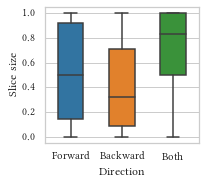

In [10]:
HEIGHT = 2.5
plt.figure(figsize=(2.75, HEIGHT))
ax = sns.boxplot(data=df, x='direction', y='line_frac', width=0.5)
ax.set_xlabel('Direction')
ax.set_ylabel('Slice size')
plt.savefig('figures/linefrac.pdf', bbox_inches='tight')

## Distribution of slice sizes by function size and direction

In [15]:
df.groupby([ 'direction', 'big_func']).line_frac.describe()[['25%', '50%', '75%']]

25%       50%       75%
direction big_func                              
Backward  False     0.111111  0.357143  0.777778
          True      0.030928  0.145511  0.435449
Both      False     0.571429  0.875000  1.000000
          True      0.246231  0.630769  0.913793
Forward   False     0.190476  0.571429  1.000000
          True      0.048780  0.297356  0.718346

## Statistical significance of difference in medians

In [12]:
from scipy.stats import kruskal
for direction in ['Forward', 'Backward', 'Both']:
    df2 = df[df.direction == direction]
    p = kruskal(df2[df2.big_func].line_frac, df2[~df2.big_func].line_frac).pvalue
    p_corrected = p / 3 # Bonferroni correction for 3 comparisons
    print(direction, p_corrected)

Forward 0.0
Backward 0.0
Both 0.0


## Figure 1-top-right

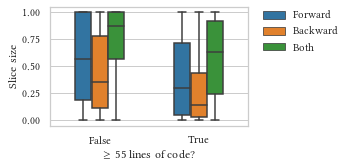

In [13]:
plt.figure(figsize=(5, HEIGHT))
ax = sns.boxplot(data=df, x='big_func', y='line_frac', hue='direction', width=0.5)
ax.set_xlabel(f'$\\geq {cutoff}$ lines of code?')
ax.set_ylabel('Slice size')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
plt.tight_layout()
plt.savefig('figures/linefrac-by-size.pdf', bbox_inches='tight')

## Figure 1-bottom

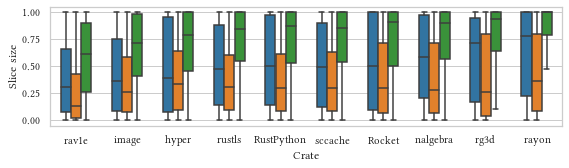

In [14]:
plt.figure(figsize=(8, HEIGHT))
order = df.groupby('crate').tok_frac.median().sort_values().index.tolist()
ax = sns.boxplot(data=df, x='crate', y='tok_frac', hue='direction', fliersize=0,  order=order, width=0.6)
ax.get_legend().remove()
ax.set_xlabel('Crate')
ax.set_ylabel('Slice size')
plt.tight_layout()
plt.savefig('figures/linefrac-by-size-crate.pdf', bbox_inches='tight')